In this tutorial we will use the exoplanet analysis package called lightkurve: "A friendly Python package for making discoveries with Kepler & TESS"

Lightkurve offers a user-friendly way to analyze time series data on the brightness of planets, stars, and galaxies. The package is focused on supporting science with NASA’s Kepler and TESS space telescopes, but can equally be used to analyze light curves obtained by your backyard telescope. Lightkurve aims to lower barriers, promote best practices, reduce costs, and improve scientific fidelity by providing accessible open source Python tools and tutorials for time domain astronomy.

https://docs.lightkurve.org/index.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import lightkurve as lk
search_result = lk.search_lightcurve("TIC 392753678")

In [17]:
print(search_result)

SearchResult containing 4 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 11 2019 TESS-SPOC    1800   392753678      0.0
  1 TESS Sector 11 2019       QLP    1800   392753678      0.0
  2 TESS Sector 38 2021 TESS-SPOC     600   392753678      0.0
  3 TESS Sector 38 2021       QLP     600   392753678      0.0


In [18]:
search_result = lk.search_lightcurve("TIC 392753678",author="TESS-SPOC")

In [19]:
print(search_result)

SearchResult containing 2 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 11 2019 TESS-SPOC    1800   392753678      0.0
  1 TESS Sector 38 2021 TESS-SPOC     600   392753678      0.0


In [29]:
lc_collection = search_result.download_all()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

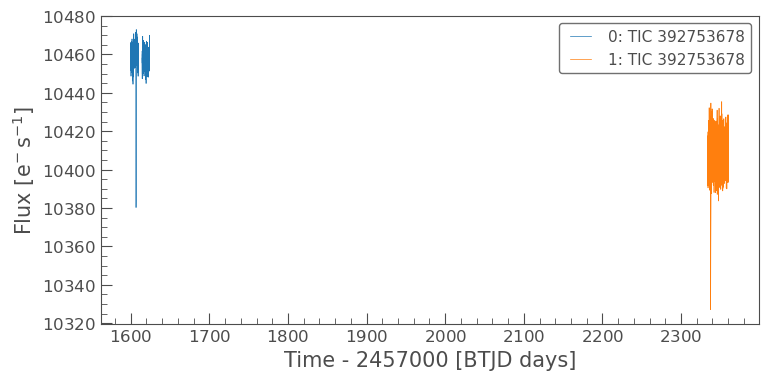

In [30]:
lc_collection.plot()

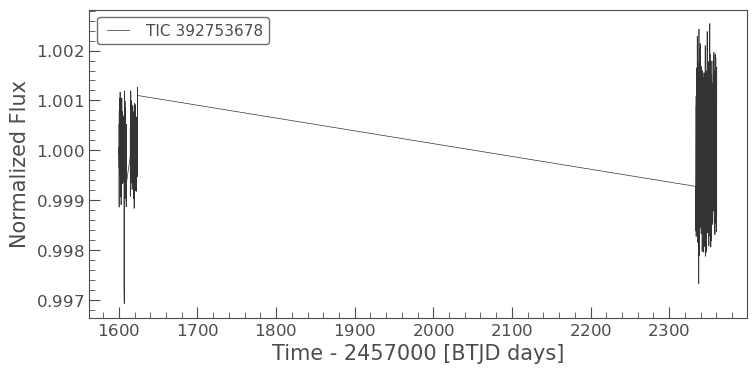

In [31]:
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot();

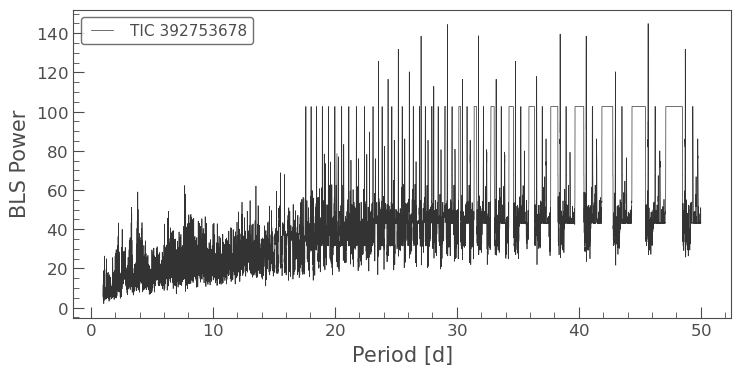

In [35]:
# Create array of periods to search
period = np.linspace(1, 50, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

The highest power spike shows the most likely period, while the lower power spikes are fractional harmonics of the period, for example, 1/2, 1/3, 1/4, etc.

In [47]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

print(planet_b_t0)

# Check the value for period
planet_b_period

1606.7137063929242


<Quantity 45.68266827 d>

To confirm that this period and transit time (epoch) correspond to a transit signal, we can phase-fold the light curve using these values and plot it.

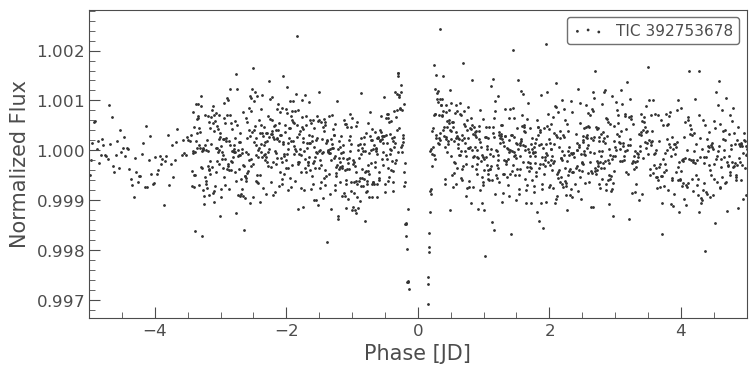

In [37]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

In [38]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

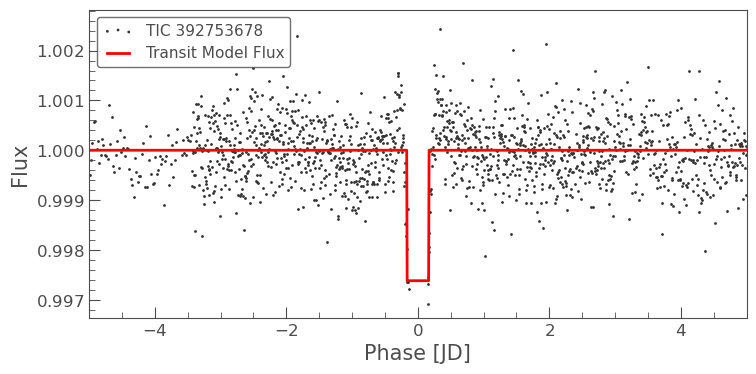

In [39]:
ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5);

In [40]:
lc.interact_bls()

In [28]:
def load(infile):
    t, f, fe = np.loadtxt(infile, usecols=[0,1,2], unpack=True)
    return t, f, fe

def plot(t, f, fe, title):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.errorbar(t, f, yerr=fe, fmt='k.')
    ax.set_xlabel('Time (JD)')
    ax.set_ylabel('Flux')
    ax.set_title(title)
    plt.show()

def plot_phased(time, flux, t0, period, title):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    #phase = (time%period)/period
    phase = (time - t0 + 0.5 * period) % period - 0.5 * period
    ax.plot(phase, flux, 'k.')
    ax.set_xlabel('Phase')
    ax.set_ylabel('Flux')
    ax.set_title(title)
    plt.show()

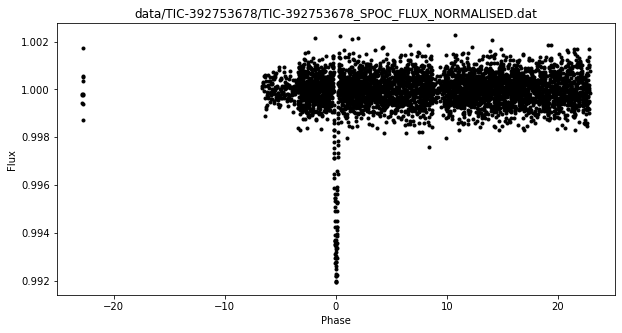

In [29]:
data_file = "data/TIC-392753678/TIC-392753678_SPOC_FLUX_NORMALISED.dat" 
t, f, fe = load(data_file)

#plot(f, f, fe, data_file)
best_period = 91.36264073778875 / 2
t0=2459337.6349254055
plot_phased(t, f, t0, best_period, data_file)